# BCI Training Pipeline - EEGNet com Dados CSV Locais

Pipeline de treinamento para BCI usando CNN personalizada baseada no EEGNet:

1. **EEGNet Personalizado**: Implementação própria PyTorch
2. **Dados CSV Locais**: Carrega todos os CSVs da pasta eeg_data (formato OpenBCI)
3. **Pipeline de Treinamento**: Cross-validation e early stopping  
4. **Normalização Robusta**: Tratamento de outliers
5. **Dados OpenBCI**: Suporte nativo para CSV da OpenBCI GUI
6. **Inferência em Tempo Real**: Compatível com sistema LSL

## 🎯 Objetivo: CNN treinada com SEUS dados reais para BCI em tempo real

**✅ SEM dados sintéticos - APENAS seus CSVs da pasta eeg_data!**

In [31]:
# === IMPORTS E CONFIGURAÇÕES BÁSICAS ===
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from pathlib import Path
import time
import mne

# Verificar device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")
print(f"🐍 PyTorch version: {torch.__version__}")

# Configurar paths
PROJECT_ROOT = Path.cwd()
MODELS_PATH = PROJECT_ROOT / "models"
RESULTS_PATH = PROJECT_ROOT / "results"

# Criar diretórios se não existirem
MODELS_PATH.mkdir(exist_ok=True)
RESULTS_PATH.mkdir(exist_ok=True)

print(f"📂 Projeto: {PROJECT_ROOT}")
print(f"🤖 Modelos: {MODELS_PATH}")
print("✅ Configurações básicas carregadas!")

🖥️ Device: cpu
🐍 PyTorch version: 2.7.1+cpu
📂 Projeto: c:\Users\Chari\OneDrive\Documentos\GitHub\projetoBCI-1
🤖 Modelos: c:\Users\Chari\OneDrive\Documentos\GitHub\projetoBCI-1\models
✅ Configurações básicas carregadas!


## 1. Setup Inicial no Google Colab

Vamos instalar as dependências e configurar o ambiente adequadamente.

# 1. Modelo EEGNet Personalizado

Implementação própria do EEGNet usando apenas PyTorch:

- **Depthwise Separable Convolutions**: Reduz parâmetros
- **Temporal e Spatial Filtering**: Especializado para EEG  
- **Dropout e Batch Normalization**: Regularização
- **Arquitetura Flexível**: Adaptável para diferentes configurações

In [42]:
# === INSTALAÇÃO DE DEPENDÊNCIAS ===
print("🔧 Instalando dependências necessárias...")

# Instalar apenas dependências essenciais para CSV locais
!pip install torch torchvision torchaudio
!pip install scikit-learn pandas numpy matplotlib seaborn
!pip install scipy pathlib

print("✅ Dependências instaladas!")

# Verificar se está no Colab
try:
    import google.colab
    print("📱 Executando no Google Colab")
except ImportError:
    print("💻 Executando localmente")

# === MODELO EEGNET (ÚNICO MODELO TREINADO) ===
class EEGNet(nn.Module):
    """Implementação compacta do EEGNet para BCI - MODELO PRINCIPAL"""
    
    def __init__(self, n_channels=16, n_classes=2, n_samples=400, 
                 dropout_rate=0.25, kernel_length=64, F1=8, D=2, F2=16):
        super(EEGNet, self).__init__()
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.n_samples = n_samples
        
        # Bloco 1: Temporal Convolution
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, F1, (1, kernel_length), padding=(0, kernel_length // 2), bias=False),
            nn.BatchNorm2d(F1)
        )
        
        # Bloco 2: Depthwise Convolution (Spatial filtering)
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(F1, F1 * D, (n_channels, 1), groups=F1, bias=False),
            nn.BatchNorm2d(F1 * D),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropout_rate)
        )
        
        # Bloco 3: Separable Convolution
        self.separableConv = nn.Sequential(
            nn.Conv2d(F1 * D, F1 * D, (1, 16), padding=(0, 8), groups=F1 * D, bias=False),
            nn.Conv2d(F1 * D, F2, 1, bias=False),
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(dropout_rate)
        )
        
        # Classificador
        self.feature_size = self._get_conv_output_size()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.feature_size, n_classes)
        )
        
        self.apply(self._init_weights)
        print(f"✅ EEGNet criado: {sum(p.numel() for p in self.parameters()):,} parâmetros")
    
    def _get_conv_output_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, self.n_channels, self.n_samples)
            x = self.firstconv(dummy_input)
            x = self.depthwiseConv(x)
            x = self.separableConv(x)
            return x.numel()
    
    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            nn.init.xavier_uniform_(module.weight)
        elif isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
    
    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)  # (batch, channels, samples) -> (batch, 1, channels, samples)
        
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = self.classifier(x)
        return x

# Teste do modelo
print("🧪 Testando modelo EEGNet...")
test_model = EEGNet(n_channels=16, n_classes=2, n_samples=400)
with torch.no_grad():
    test_input = torch.randn(2, 16, 400)
    test_output = test_model(test_input)
    print(f"✅ Teste: {test_input.shape} -> {test_output.shape}")
del test_model

🔧 Instalando dependências necessárias...



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Dependências instaladas!
💻 Executando localmente
🧪 Testando modelo EEGNet...
✅ EEGNet criado: 1,746 parâmetros
✅ Teste: torch.Size([2, 16, 400]) -> torch.Size([2, 2])



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
# === CLASSES AUXILIARES PARA TREINAMENTO ===

# === CARREGAMENTO DE DADOS E NORMALIZAÇÃO ===
class RobustEEGNormalizer:
    """Normalizador robusto para dados EEG"""
    
    def __init__(self, method='robust_zscore', outlier_threshold=3.0):
        self.method = method
        self.outlier_threshold = outlier_threshold
        self.stats = {}
        self.is_fitted = False
    
    def fit(self, X):
        # Garantir formato 3D (trials, channels, time)
        if len(X.shape) == 2:
            X = X.reshape(X.shape[0], 16, -1)
        
        # Tratar outliers usando IQR
        Q1 = np.percentile(X, 25, axis=(0, 2), keepdims=True)
        Q3 = np.percentile(X, 75, axis=(0, 2), keepdims=True)
        IQR = Q3 - Q1
        lower = Q1 - self.outlier_threshold * IQR
        upper = Q3 + self.outlier_threshold * IQR
        X = np.clip(X, lower, upper)
        
        # Calcular estatísticas por canal
        self.stats['median'] = np.median(X, axis=(0, 2), keepdims=True)
        self.stats['iqr'] = IQR + 1e-8
        self.is_fitted = True
        return self
    
    def transform(self, X):
        if not self.is_fitted:
            raise ValueError("Deve ajustar antes de transformar")
        
        original_shape = X.shape
        if len(X.shape) == 2:
            X = X.reshape(X.shape[0], 16, -1)
        
        X_norm = (X - self.stats['median']) / self.stats['iqr']
        
        if len(original_shape) == 2:
            X_norm = X_norm.reshape(original_shape)
        return X_norm
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    
    def get_stats(self):
        return self.stats.copy()

# === DATASET PYTORCH ===
class EEGDataset(Dataset):
    def __init__(self, windows, labels, augment=False):
        self.windows = torch.from_numpy(windows).float()
        self.labels = torch.from_numpy(labels).long()
        self.augment = augment
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        window = self.windows[idx]
        label = self.labels[idx]
        
        if self.augment and torch.rand(1) < 0.3:
            # Adicionar ruído leve para augmentação
            noise = torch.randn_like(window) * 0.01
            window = window + noise
        
        return window, label


In [44]:
# === CARREGAMENTO DOS DADOS CSV LOCAIS (OpenBCI) ===
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt
import glob

def load_openbci_csv_data(data_folder="eeg_data", n_samples_per_trial=400, n_channels=16, 
                         trial_duration=3.2, overlap_samples=50):
    """
    Carrega todos os dados CSV da pasta eeg_data (formato OpenBCI GUI)
    
    Args:
        data_folder: Pasta com dados organizados por sujeito (S001, S002, etc.)
        n_samples_per_trial: Amostras por trial após reamostragem 
        n_channels: Número de canais EEG (16 para OpenBCI)
        trial_duration: Duração do trial em segundos (3.2s)
        overlap_samples: Amostras antes do evento para incluir no trial
    """
    print(f"🚀 CARREGAMENTO DE DADOS CSV LOCAIS (OpenBCI)")
    print(f"   Pasta de dados: {data_folder}")
    print(f"   Amostras por trial: {n_samples_per_trial}")
    print(f"   Canais esperados: {n_channels}")
    print(f"   Duração do trial: {trial_duration}s")
    
    # Caminhos dos dados
    data_path = Path(data_folder)
    if not data_path.exists():
        raise ValueError(f"❌ Pasta {data_folder} não encontrada!")
    
    all_trials = []
    all_labels = []
    all_subjects = []
    successful_subjects = 0
    total_files = 0
    
    # Mapear eventos para classes
    event_mapping = {'T1': 0, 'T2': 1}  # T1=mão esquerda, T2=mão direita
    
    # Processar cada pasta de sujeito
    subject_folders = sorted([d for d in data_path.iterdir() if d.is_dir() and d.name.startswith('S')])
    
    for subject_folder in subject_folders:
        subject_id = subject_folder.name  # S001, S002, etc.
        print(f"   📂 Processando {subject_id}...")
        
        # Encontrar arquivos CSV
        csv_files = list(subject_folder.glob("*.csv"))
        if not csv_files:
            print(f"     ⚠️ Nenhum CSV encontrado em {subject_id}")
            continue
            
        subject_trials = 0
        subject_successful = False
        
        for csv_file in csv_files:
            total_files += 1
            print(f"     📄 Carregando {csv_file.name}...")
            
            try:
                # Ler CSV pulando cabeçalho da OpenBCI
                df = pd.read_csv(csv_file, skiprows=4, low_memory=False)
                
                # Verificar se tem as colunas necessárias
                eeg_columns = [f'EXG Channel {i}' for i in range(16)]
                if not all(col in df.columns for col in eeg_columns):
                    print(f"       ⚠️ Colunas EEG não encontradas em {csv_file.name}")
                    continue
                
                # Extrair dados EEG (16 canais)
                eeg_data = df[eeg_columns].values.astype(float)  # (samples, channels)
                annotations = df['Annotations'].fillna('').astype(str)
                
                # Frequência de amostragem (125 Hz da OpenBCI)
                fs = 125.0
                
                # Filtro passa-banda 1-40 Hz
                nyquist = fs / 2
                low_freq = 1.0 / nyquist
                high_freq = 40.0 / nyquist
                b, a = butter(4, [low_freq, high_freq], btype='band')
                
                # Aplicar filtro a cada canal
                eeg_filtered = np.zeros_like(eeg_data)
                for ch in range(eeg_data.shape[1]):
                    if np.any(np.isfinite(eeg_data[:, ch])):  # Verificar se há dados válidos
                        eeg_filtered[:, ch] = filtfilt(b, a, eeg_data[:, ch])
                
                # Encontrar eventos T1 e T2
                event_indices = []
                event_labels = []
                
                for idx, annotation in enumerate(annotations):
                    if annotation in event_mapping:
                        event_indices.append(idx)
                        event_labels.append(event_mapping[annotation])
                
                if len(event_indices) == 0:
                    print(f"       ⚠️ Nenhum evento T1/T2 encontrado em {csv_file.name}")
                    continue
                
                print(f"       ✅ {len(event_indices)} eventos encontrados")
                
                # Extrair trials baseados nos eventos
                trial_samples = int(trial_duration * fs)  # Amostras por trial
                
                for event_idx, event_label in zip(event_indices, event_labels):
                    # Definir janela do trial
                    start_idx = max(0, event_idx - overlap_samples)
                    end_idx = min(len(eeg_filtered), start_idx + trial_samples)
                    
                    if end_idx - start_idx < trial_samples * 0.8:  # Pelo menos 80% do trial
                        continue
                    
                    # Extrair trial
                    trial_data = eeg_filtered[start_idx:end_idx, :].T  # (channels, time)
                    
                    # Redimensionar para n_samples_per_trial se necessário
                    if trial_data.shape[1] != n_samples_per_trial:
                        # Interpolar para o tamanho correto
                        old_time = np.linspace(0, 1, trial_data.shape[1])
                        new_time = np.linspace(0, 1, n_samples_per_trial)
                        
                        trial_resampled = np.zeros((n_channels, n_samples_per_trial))
                        for ch in range(min(trial_data.shape[0], n_channels)):
                            if np.any(np.isfinite(trial_data[ch, :])):
                                f = interp1d(old_time, trial_data[ch, :], kind='linear', 
                                           bounds_error=False, fill_value='extrapolate')
                                trial_resampled[ch, :] = f(new_time)
                        trial_data = trial_resampled
                    
                    # Garantir exatamente n_channels canais
                    if trial_data.shape[0] < n_channels:
                        # Preencher com zeros
                        padding = np.zeros((n_channels - trial_data.shape[0], trial_data.shape[1]))
                        trial_data = np.vstack([trial_data, padding])
                    elif trial_data.shape[0] > n_channels:
                        # Truncar
                        trial_data = trial_data[:n_channels, :]
                    
                    # Verificar se há dados válidos
                    if not np.any(np.isfinite(trial_data)):
                        continue
                    
                    # Adicionar aos dados globais
                    all_trials.append(trial_data)
                    all_labels.append(event_label)
                    all_subjects.append(subject_id)
                    subject_trials += 1
                
                subject_successful = True
                
            except Exception as e:
                print(f"       ❌ Erro ao processar {csv_file.name}: {str(e)[:80]}")
                continue
        
        if subject_successful:
            successful_subjects += 1
            print(f"   ✅ {subject_id}: {subject_trials} trials extraídos")
        else:
            print(f"   ❌ {subject_id}: Falha no processamento")
    
    if all_trials:
        # Converter para numpy arrays
        windows = np.array(all_trials)  # (n_trials, n_channels, n_samples)
        labels = np.array(all_labels)
        subject_ids = np.array(all_subjects)
        
        print(f"\n🎉 DADOS CSV CARREGADOS COM SUCESSO!")
        print(f"   📊 Shape final: {windows.shape}")
        print(f"   🎯 Total de trials: {len(windows)}")
        print(f"   📁 Arquivos processados: {total_files}")
        print(f"   👥 Sujeitos bem-sucedidos: {successful_subjects}/{len(subject_folders)}")
        print(f"   📈 Classes: {dict(zip(*np.unique(labels, return_counts=True)))}")
        
        return windows, labels, subject_ids
    else:
        raise ValueError("❌ Nenhum dado foi carregado! Verifique os arquivos CSV e anotações.")

# === EXECUTAR CARREGAMENTO DOS DADOS CSV LOCAIS ===
print("🚀 CARREGAMENTO DE DADOS CSV LOCAIS (OpenBCI)")
print("="*70)

try:
    # Carregar todos os dados CSV da pasta eeg_data
    windows, labels, subject_ids = load_openbci_csv_data(
        data_folder="eeg_data",
        n_samples_per_trial=400,  # Manter compatibilidade com o modelo
        n_channels=16,            # OpenBCI padrão
        trial_duration=3.2,       # 3.2 segundos por trial
        overlap_samples=50        # 50 amostras antes do evento
    )
    
    print(f"\n✅ DATASET CSV CARREGADO COM SUCESSO!")
    print(f"🎯 Shape final: {windows.shape}")
    print(f"📊 Distribuição de classes: {dict(zip(*np.unique(labels, return_counts=True)))}")
    print(f"👥 Sujeitos incluídos: {sorted(np.unique(subject_ids))}")
    
    # Estatísticas detalhadas
    print(f"\n📈 ESTATÍSTICAS DETALHADAS:")
    print(f"   Total de trials: {len(windows)}")
    print(f"   Trials por classe: {dict(zip(*np.unique(labels, return_counts=True)))}")
    print(f"   Trials por sujeito: {dict(zip(*np.unique(subject_ids, return_counts=True)))}")
    print(f"   Frequência de amostragem: 125 Hz (OpenBCI)")
    print(f"   Duração por trial: 3.2 segundos")
    print(f"   Canais EEG: {windows.shape[1]}")
    print(f"   Tamanho total do dataset: {windows.nbytes / (1024**2):.1f} MB")
    
    # Verificar balanceamento
    class_balance = dict(zip(*np.unique(labels, return_counts=True)))
    balance_ratio = min(class_balance.values()) / max(class_balance.values())
    print(f"   Balanceamento das classes: {balance_ratio:.2f} ({'✅ Balanceado' if balance_ratio > 0.8 else '⚠️ Desbalanceado'})")
    
    # Verificar qualidade dos dados
    nan_trials = np.sum([np.any(np.isnan(trial)) for trial in windows])
    inf_trials = np.sum([np.any(np.isinf(trial)) for trial in windows])
    print(f"   Trials com NaN: {nan_trials}")
    print(f"   Trials com Inf: {inf_trials}")
    
    # Informações das classes
    print(f"\n📋 INFORMAÇÕES DAS CLASSES:")
    print(f"   Classe 0 (T1): Movimento/Imaginação da mão esquerda")
    print(f"   Classe 1 (T2): Movimento/Imaginação da mão direita")
    
except Exception as e:
    print(f"❌ ERRO CRÍTICO ao carregar dados CSV: {e}")
    print(f"💡 Possíveis soluções:")
    print(f"   1. Verificar se a pasta 'eeg_data' existe")
    print(f"   2. Verificar se os CSVs têm o formato correto da OpenBCI")
    print(f"   3. Verificar se há anotações T1/T2 nos arquivos")
    import traceback
    traceback.print_exc()
    raise ValueError(f"Não foi possível carregar dados CSV: {e}")

print("\n🎯 DADOS CSV CARREGADOS - PRONTO PARA TREINAMENTO!")
print("="*70)

🚀 CARREGAMENTO DE DADOS CSV LOCAIS (OpenBCI)
🚀 CARREGAMENTO DE DADOS CSV LOCAIS (OpenBCI)
   Pasta de dados: eeg_data
   Amostras por trial: 400
   Canais esperados: 16
   Duração do trial: 3.2s
   📂 Processando S001...
     📄 Carregando S001R04_csv_openbci.csv...
       ✅ 15 eventos encontrados
     📄 Carregando S001R08_csv_openbci.csv...
       ✅ 15 eventos encontrados
     📄 Carregando S001R12_csv_openbci.csv...
       ✅ 15 eventos encontrados
   ✅ S001: 45 trials extraídos
   📂 Processando S002...
     📄 Carregando S002R04_csv_openbci.csv...
       ✅ 15 eventos encontrados
     📄 Carregando S002R08_csv_openbci.csv...
       ✅ 15 eventos encontrados
     📄 Carregando S002R12_csv_openbci.csv...
       ✅ 15 eventos encontrados
   ✅ S002: 45 trials extraídos
   📂 Processando S003...
     📄 Carregando S003R04_csv_openbci.csv...
       ✅ 15 eventos encontrados
     📄 Carregando S003R08_csv_openbci.csv...
       ✅ 15 eventos encontrados
     📄 Carregando S003R12_csv_openbci.csv...
       

🎨 CRIANDO VISUALIZAÇÕES DOS DADOS CSV (OpenBCI)...
📊 GERANDO VISUALIZAÇÕES DOS DADOS CSV (OpenBCI)...


C:\Users\Chari\AppData\Local\Temp\ipykernel_22972\1883944174.py:287: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\Chari\AppData\Local\Temp\ipykernel_22972\1883944174.py:287: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\Chari\AppData\Local\Temp\ipykernel_22972\1883944174.py:287: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\Chari\AppData\Local\Temp\ipykernel_22972\1883944174.py:287: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\Chari\AppData\Local\Temp\ipykernel_22972\1883944174.py:287: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\Chari\AppData\Local\Temp\ipykernel_22972\1883944174.py:287: UserW

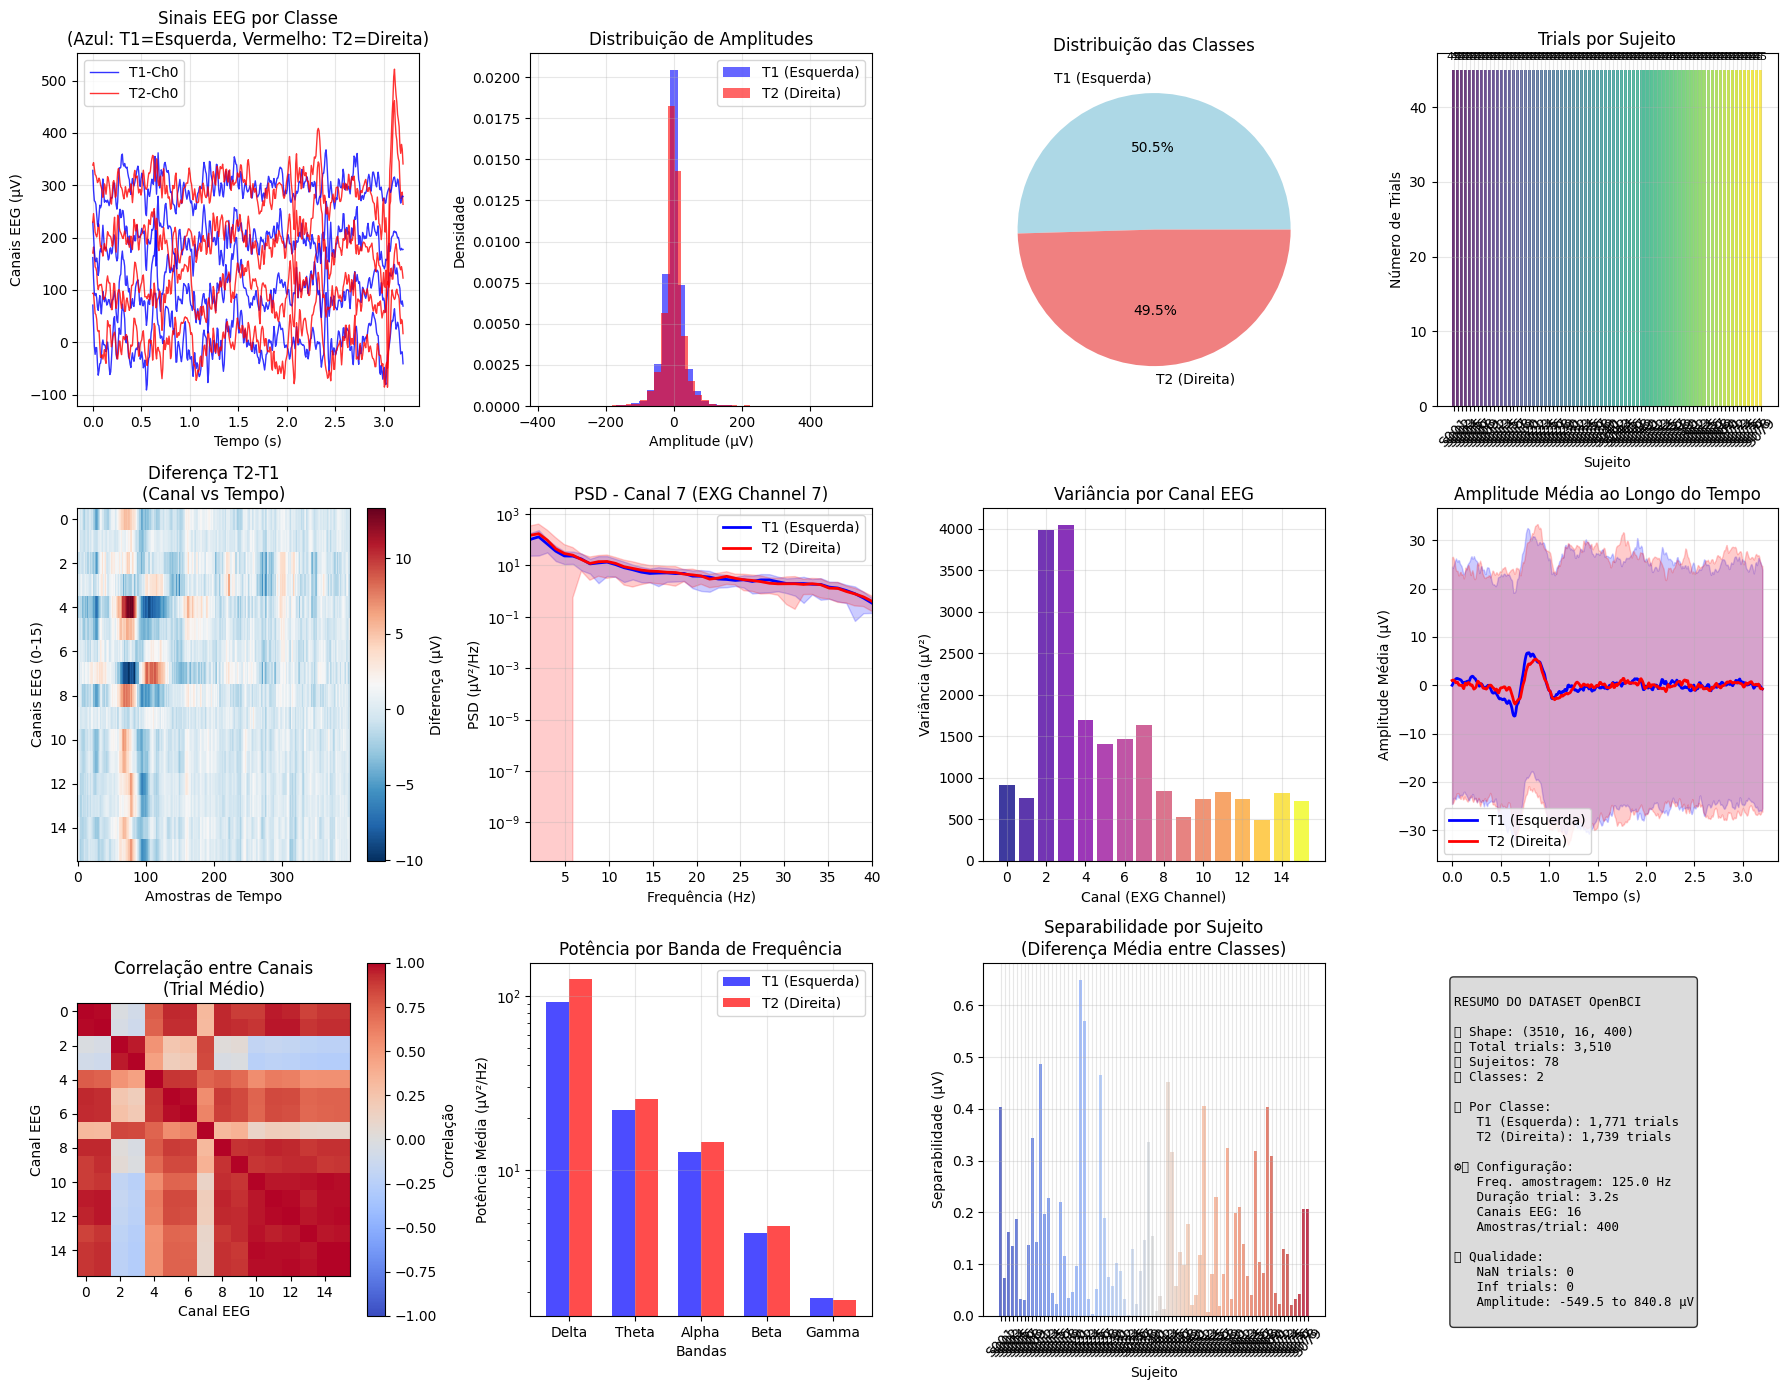


📈 ESTATÍSTICAS DETALHADAS DOS DADOS CSV:
   Shape dos dados: (3510, 16, 400)
   Amplitude mínima: -549.46 μV
   Amplitude máxima: 840.84 μV
   Amplitude média: 0.01 μV
   Desvio padrão: 36.81 μV
   Frequência de amostragem: 125.0 Hz (OpenBCI)
   Duração por trial: 3.2 segundos

   📊 T1 (Mão Esquerda):
      Trials: 1,771
      Amplitude média: 0.02 μV
      Desvio padrão: 36.44 μV
      SNR estimado: 0.00

   📊 T2 (Mão Direita):
      Trials: 1,739
      Amplitude média: 0.01 μV
      Desvio padrão: 37.18 μV
      SNR estimado: 0.00
✅ Visualizações concluídas!
      Desvio padrão: 37.18 μV
      SNR estimado: 0.00
✅ Visualizações concluídas!


In [45]:
# === VISUALIZAÇÃO DOS DADOS CSV CARREGADOS (OpenBCI) ===
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

def plot_eeg_data_analysis(windows, labels, subject_ids):
    """Visualização completa dos dados EEG carregados da pasta eeg_data"""
    
    print("📊 GERANDO VISUALIZAÇÕES DOS DADOS CSV (OpenBCI)...")
    
    # Configurar estilo dos plots
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Criar figura com subplots
    fig = plt.figure(figsize=(18, 14))
    
    # Parâmetros dos dados OpenBCI
    fs = 125.0  # Frequência de amostragem OpenBCI
    trial_duration = 3.2  # Duração do trial em segundos
    time_axis = np.linspace(0, trial_duration, windows.shape[2])
    
    # 1. Exemplo de trial de cada classe
    plt.subplot(3, 4, 1)
    if np.sum(labels == 0) > 0 and np.sum(labels == 1) > 0:
        class_0_idx = np.where(labels == 0)[0][0]
        class_1_idx = np.where(labels == 1)[0][0]
        
        # Plot primeiros 4 canais de cada classe
        for i in range(min(4, windows.shape[1])):
            offset = i * 100  # Offset maior para dados OpenBCI
            plt.plot(time_axis, windows[class_0_idx, i, :] + offset, 
                    color='blue', alpha=0.8, linewidth=1.0, label=f'T1-Ch{i}' if i == 0 else "")
            plt.plot(time_axis, windows[class_1_idx, i, :] + offset, 
                    color='red', alpha=0.8, linewidth=1.0, label=f'T2-Ch{i}' if i == 0 else "")
        
        plt.title('Sinais EEG por Classe\n(Azul: T1=Esquerda, Vermelho: T2=Direita)')
        plt.xlabel('Tempo (s)')
        plt.ylabel('Canais EEG (μV)')
        plt.grid(True, alpha=0.3)
        if len(np.unique(labels)) == 2:
            plt.legend()
    
    # 2. Distribuição de amplitudes por classe
    plt.subplot(3, 4, 2)
    for class_label in np.unique(labels):
        class_data = windows[labels == class_label].flatten()
        # Usar amostra menor para velocidade
        sample_size = min(10000, len(class_data))
        sample_data = np.random.choice(class_data, sample_size, replace=False)
        class_name = 'T1 (Esquerda)' if class_label == 0 else 'T2 (Direita)'
        color = 'blue' if class_label == 0 else 'red'
        plt.hist(sample_data, bins=40, alpha=0.6, label=class_name, color=color, density=True)
    
    plt.title('Distribuição de Amplitudes')
    plt.xlabel('Amplitude (μV)')
    plt.ylabel('Densidade')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Distribuição por classes (Pie Chart)
    plt.subplot(3, 4, 3)
    unique_labels, counts = np.unique(labels, return_counts=True)
    colors = ['lightblue', 'lightcoral'] if len(unique_labels) == 2 else plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
    labels_pie = ['T1 (Esquerda)', 'T2 (Direita)'] if len(unique_labels) == 2 else [f'Classe {i}' for i in unique_labels]
    wedges, texts, autotexts = plt.pie(counts, labels=labels_pie, autopct='%1.1f%%', colors=colors)
    plt.title('Distribuição das Classes')
    
    # 4. Trials por sujeito
    plt.subplot(3, 4, 4)
    unique_subjects, subject_counts = np.unique(subject_ids, return_counts=True)
    colors_subjects = plt.cm.viridis(np.linspace(0, 1, len(unique_subjects)))
    bars = plt.bar(range(len(unique_subjects)), subject_counts, color=colors_subjects, alpha=0.8)
    plt.title('Trials por Sujeito')
    plt.xlabel('Sujeito')
    plt.ylabel('Número de Trials')
    plt.xticks(range(len(unique_subjects)), unique_subjects, rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Adicionar valores nas barras
    for bar, count in zip(bars, subject_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                str(count), ha='center', va='bottom', fontsize=8)
    
    # 5. Mapa de calor - Canal vs Tempo (diferença entre classes)
    plt.subplot(3, 4, 5)
    if len(np.unique(labels)) == 2:
        mean_class_0 = np.mean(windows[labels == 0], axis=0)
        mean_class_1 = np.mean(windows[labels == 1], axis=0)
        diff_map = mean_class_1 - mean_class_0
        
        im = plt.imshow(diff_map, aspect='auto', cmap='RdBu_r', interpolation='nearest')
        plt.title('Diferença T2-T1\n(Canal vs Tempo)')
        plt.xlabel('Amostras de Tempo')
        plt.ylabel('Canais EEG (0-15)')
        plt.colorbar(im, label='Diferença (μV)')
        
        # Adicionar ticks dos canais
        plt.yticks(range(0, windows.shape[1], 2), range(0, windows.shape[1], 2))
    
    # 6. Densidade Espectral de Potência (PSD)
    plt.subplot(3, 4, 6)
    channel_idx = 7  # Canal central (aproximadamente C3/C4)
    
    for class_label in np.unique(labels):
        class_trials = windows[labels == class_label]
        psd_list = []
        
        # Calcular PSD para amostra de trials
        n_samples = min(30, len(class_trials))
        for i in range(n_samples):
            freqs, psd = signal.welch(class_trials[i, channel_idx, :], 
                                    fs=fs, nperseg=min(128, windows.shape[2]//2))
            psd_list.append(psd)
        
        mean_psd = np.mean(psd_list, axis=0)
        std_psd = np.std(psd_list, axis=0)
        class_name = 'T1 (Esquerda)' if class_label == 0 else 'T2 (Direita)'
        color = 'blue' if class_label == 0 else 'red'
        
        plt.semilogy(freqs, mean_psd, label=class_name, color=color, linewidth=2)
        plt.fill_between(freqs, mean_psd - std_psd, mean_psd + std_psd, 
                        alpha=0.2, color=color)
    
    plt.title(f'PSD - Canal {channel_idx} (EXG Channel {channel_idx})')
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('PSD (μV²/Hz)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(1, 40)  # Foco em 1-40 Hz
    
    # 7. Variância por canal
    plt.subplot(3, 4, 7)
    channel_variances = np.var(windows, axis=(0, 2))
    bars = plt.bar(range(len(channel_variances)), channel_variances, 
                  color=plt.cm.plasma(np.linspace(0, 1, len(channel_variances))), alpha=0.8)
    plt.title('Variância por Canal EEG')
    plt.xlabel('Canal (EXG Channel)')
    plt.ylabel('Variância (μV²)')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0, len(channel_variances), 2), range(0, len(channel_variances), 2))
    
    # 8. Evolução temporal da amplitude média
    plt.subplot(3, 4, 8)
    for class_label in np.unique(labels):
        class_data = windows[labels == class_label]
        mean_amplitude = np.mean(class_data, axis=(0, 1))  # Média sobre trials e canais
        std_amplitude = np.std(np.mean(class_data, axis=1), axis=0)  # Std da média por trial
        
        class_name = 'T1 (Esquerda)' if class_label == 0 else 'T2 (Direita)'
        color = 'blue' if class_label == 0 else 'red'
        
        plt.plot(time_axis, mean_amplitude, label=class_name, color=color, linewidth=2)
        plt.fill_between(time_axis, mean_amplitude - std_amplitude, 
                        mean_amplitude + std_amplitude, alpha=0.2, color=color)
    
    plt.title('Amplitude Média ao Longo do Tempo')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude Média (μV)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 9. Correlação entre canais (trial médio)
    plt.subplot(3, 4, 9)
    # Usar médias das classes para correlação
    if len(np.unique(labels)) == 2:
        mean_trial = np.mean(windows, axis=0)  # Média de todos os trials
    else:
        mean_trial = windows[0, :, :]  # Primeiro trial se não houver 2 classes
    
    correlation_matrix = np.corrcoef(mean_trial)
    
    im = plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlação entre Canais\n(Trial Médio)')
    plt.xlabel('Canal EEG')
    plt.ylabel('Canal EEG')
    plt.colorbar(im, label='Correlação')
    
    # Adicionar ticks dos canais
    plt.xticks(range(0, windows.shape[1], 2), range(0, windows.shape[1], 2))
    plt.yticks(range(0, windows.shape[1], 2), range(0, windows.shape[1], 2))
    
    # 10. Bandas de frequência por classe (Novo!)
    plt.subplot(3, 4, 10)
    # Definir bandas de frequência
    bands = {'Delta': (1, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 
             'Beta': (13, 30), 'Gamma': (30, 40)}
    
    band_powers = {band: [] for band in bands}
    class_names = []
    
    for class_label in np.unique(labels):
        class_trials = windows[labels == class_label]
        class_name = 'T1' if class_label == 0 else 'T2'
        class_names.append(class_name)
        
        for band, (low, high) in bands.items():
            powers = []
            for i in range(min(20, len(class_trials))):  # Amostra para velocidade
                freqs, psd = signal.welch(class_trials[i, channel_idx, :], fs=fs, 
                                        nperseg=min(128, windows.shape[2]//2))
                band_mask = (freqs >= low) & (freqs <= high)
                band_power = np.mean(psd[band_mask])
                powers.append(band_power)
            band_powers[band].append(np.mean(powers))
    
    x = np.arange(len(bands))
    width = 0.35
    
    for i, class_name in enumerate(class_names):
        values = [band_powers[band][i] for band in bands]
        color = 'blue' if class_name == 'T1' else 'red'
        plt.bar(x + i*width, values, width, label=f'{class_name} ({'Esquerda' if class_name == 'T1' else 'Direita'})', 
               color=color, alpha=0.7)
    
    plt.title('Potência por Banda de Frequência')
    plt.xlabel('Bandas')
    plt.ylabel('Potência Média (μV²/Hz)')
    plt.xticks(x + width/2, bands.keys())
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # 11. Estatísticas por sujeito
    plt.subplot(3, 4, 11)
    subject_stats = []
    for subject in unique_subjects:
        subject_mask = subject_ids == subject
        subject_data = windows[subject_mask]
        subject_labels = labels[subject_mask]
        
        # Calcular acurácia teórica baseada na separabilidade
        if len(np.unique(subject_labels)) == 2:
            class_0_mean = np.mean(subject_data[subject_labels == 0])
            class_1_mean = np.mean(subject_data[subject_labels == 1])
            separation = abs(class_1_mean - class_0_mean)
            subject_stats.append(separation)
        else:
            subject_stats.append(0)
    
    bars = plt.bar(range(len(unique_subjects)), subject_stats, 
                  color=plt.cm.coolwarm(np.linspace(0, 1, len(unique_subjects))), alpha=0.8)
    plt.title('Separabilidade por Sujeito\n(Diferença Média entre Classes)')
    plt.xlabel('Sujeito')
    plt.ylabel('Separabilidade (μV)')
    plt.xticks(range(len(unique_subjects)), unique_subjects, rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 12. Resumo do Dataset
    plt.subplot(3, 4, 12)
    plt.axis('off')
    
    # Texto com estatísticas
    stats_text = f"""
RESUMO DO DATASET OpenBCI

📊 Shape: {windows.shape}
🎯 Total trials: {len(windows):,}
👥 Sujeitos: {len(unique_subjects)}
🔄 Classes: {len(np.unique(labels))}

📈 Por Classe:
"""
    
    for class_label in np.unique(labels):
        class_count = np.sum(labels == class_label)
        class_name = 'T1 (Esquerda)' if class_label == 0 else 'T2 (Direita)'
        stats_text += f"   {class_name}: {class_count:,} trials\n"
    
    stats_text += f"""
⚙️ Configuração:
   Freq. amostragem: {fs} Hz
   Duração trial: {trial_duration}s
   Canais EEG: {windows.shape[1]}
   Amostras/trial: {windows.shape[2]}

📋 Qualidade:
   NaN trials: {np.sum([np.any(np.isnan(trial)) for trial in windows])}
   Inf trials: {np.sum([np.any(np.isinf(trial)) for trial in windows])}
   Amplitude: {np.min(windows):.1f} to {np.max(windows):.1f} μV
"""
    
    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
            fontsize=9, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Estatísticas detalhadas no console
    print(f"\n📈 ESTATÍSTICAS DETALHADAS DOS DADOS CSV:")
    print(f"   Shape dos dados: {windows.shape}")
    print(f"   Amplitude mínima: {np.min(windows):.2f} μV")
    print(f"   Amplitude máxima: {np.max(windows):.2f} μV")
    print(f"   Amplitude média: {np.mean(windows):.2f} μV")
    print(f"   Desvio padrão: {np.std(windows):.2f} μV")
    print(f"   Frequência de amostragem: {fs} Hz (OpenBCI)")
    print(f"   Duração por trial: {trial_duration} segundos")
    
    # Análise por classe
    for class_label in np.unique(labels):
        class_data = windows[labels == class_label]
        class_name = 'T1 (Mão Esquerda)' if class_label == 0 else 'T2 (Mão Direita)'
        print(f"\n   📊 {class_name}:")
        print(f"      Trials: {len(class_data):,}")
        print(f"      Amplitude média: {np.mean(class_data):.2f} μV")
        print(f"      Desvio padrão: {np.std(class_data):.2f} μV")
        print(f"      SNR estimado: {np.mean(class_data) / np.std(class_data):.2f}")

# Executar visualização se os dados estão carregados
if 'windows' in locals() and 'labels' in locals() and 'subject_ids' in locals():
    print("🎨 CRIANDO VISUALIZAÇÕES DOS DADOS CSV (OpenBCI)...")
    plot_eeg_data_analysis(windows, labels, subject_ids)
    print("✅ Visualizações concluídas!")
else:
    print("⚠️ Dados não encontrados. Execute primeiro a célula de carregamento dos dados CSV.")
    print("💡 Variáveis esperadas: 'windows', 'labels', 'subject_ids'")
    if 'windows' in locals():
        print(f"   ✅ 'windows' encontrado: {windows.shape}")
    if 'labels' in locals():
        print(f"   ✅ 'labels' encontrado: {len(labels)} trials")
    if 'subject_ids' in locals():
        print(f"   ✅ 'subject_ids' encontrado: {len(np.unique(subject_ids))} sujeitos")

In [48]:
# === PIPELINE DE TREINAMENTO DO MODELO ===
def train_eegnet_model(windows, labels, subject_ids, params):
    """Pipeline completo de treinamento do modelo EEGNet (ÚNICO MODELO TREINADO)"""
    
    print("🚀 Iniciando treinamento...")
    
    # Normalização usando o normalizador da célula anterior
    normalizer = RobustEEGNormalizer()
    windows_norm = normalizer.fit_transform(windows)
    print(f"✅ Normalização: média={np.mean(windows_norm):.4f}, std={np.std(windows_norm):.4f}")
    
    # Split treino/teste estratificado por sujeito
    unique_subjects = np.unique(subject_ids)
    test_subjects = np.random.choice(unique_subjects, size=max(1, len(unique_subjects)//5), replace=False)
    
    test_mask = np.isin(subject_ids, test_subjects)
    X_test, y_test = windows_norm[test_mask], labels[test_mask]
    X_train_val, y_train_val = windows_norm[~test_mask], labels[~test_mask]
    subject_train_val = subject_ids[~test_mask]
    
    print(f"📊 Train/Val: {len(X_train_val)} | Test: {len(X_test)}")
    print(f"👥 Test subjects: {test_subjects}")
    
    # Cross-validation
    kfold = KFold(n_splits=params.get('n_folds', 5), shuffle=True, random_state=42)
    fold_accuracies = []
    best_model_state = None
    best_val_acc = 0.0
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_val), 1):
        print(f"\n📁 Fold {fold}")
        
        # Dados do fold
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
        
        # DataLoaders com batch size menor para dados reais
        train_dataset = EEGDataset(X_train, y_train, augment=True)
        val_dataset = EEGDataset(X_val, y_val, augment=False)
        train_loader = DataLoader(train_dataset, batch_size=params.get('batch_size', 8), shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=params.get('batch_size', 8), shuffle=False)
        
        # MODELO QUE É REALMENTE TREINADO: EEGNet com mais regularização
        model = EEGNet(
            n_channels=windows.shape[1],
            n_classes=len(np.unique(labels)),
            n_samples=windows.shape[2],
            dropout_rate=0.5,  # Maior dropout para dados reais
            F1=4,              # Menos filtros para evitar overfitting
            D=2,
            F2=8
        ).to(device)
        
        # Otimizador com weight decay para regularização L2
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=params.get('learning_rate', 5e-4),  # Learning rate menor
            weight_decay=params.get('weight_decay', 1e-4)
        )
        criterion = nn.CrossEntropyLoss()
        
        # Scheduler para reduzir learning rate (SEM verbose para compatibilidade)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=5
        )
        
        # Treinamento
        best_fold_val_acc = 0.0
        patience_count = 0
        
        for epoch in range(params.get('n_epochs', 50)):
            # Treino
            model.train()
            train_loss, train_correct, train_total = 0.0, 0, 0
            
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                
                # Gradient clipping para estabilidade
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += batch_y.size(0)
                train_correct += (predicted == batch_y).sum().item()
            
            # Validação
            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            
            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    outputs = model(batch_x)
                    loss = criterion(outputs, batch_y)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_total += batch_y.size(0)
                    val_correct += (predicted == batch_y).sum().item()
            
            train_acc = train_correct / train_total
            val_acc = val_correct / val_total
            
            # Scheduler step
            scheduler.step(val_acc)
            
            # Early stopping mais rigoroso
            if val_acc > best_fold_val_acc:
                best_fold_val_acc = val_acc
                patience_count = 0
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_model_state = model.state_dict().copy()
            else:
                patience_count += 1
                if patience_count >= params.get('patience', 8):  # Patience menor
                    print(f"     Early stopping na época {epoch+1}")
                    break
            
            if (epoch + 1) % 10 == 0:
                print(f"   Época {epoch+1}: Train {train_acc:.3f} | Val {val_acc:.3f}")
        
        fold_accuracies.append(best_fold_val_acc)
        print(f"   ✅ Fold {fold} concluído - Val Acc: {best_fold_val_acc:.4f}")
    
    # Estatísticas CV
    cv_mean = np.mean(fold_accuracies)
    cv_std = np.std(fold_accuracies)
    print(f"\n📊 CV: {cv_mean:.4f} ± {cv_std:.4f}")
    
    # Teste final
    if best_model_state is not None:
        final_model = EEGNet(
            n_channels=windows.shape[1],
            n_classes=len(np.unique(labels)),
            n_samples=windows.shape[2],
            dropout_rate=0.5,
            F1=4, D=2, F2=8
        ).to(device)
        final_model.load_state_dict(best_model_state)
        final_model.eval()
        
        test_dataset = EEGDataset(X_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
        
        test_correct = test_total = 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = final_model(batch_x)
                _, predicted = torch.max(outputs, 1)
                test_total += batch_y.size(0)
                test_correct += (predicted == batch_y).sum().item()
        
        test_acc = test_correct / test_total
        print(f"🎯 Teste final: {test_acc:.4f}")
    else:
        test_acc = 0.0
        final_model = None
    
    results = {
        'model_state_dict': best_model_state,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'test_accuracy': test_acc,
        'normalization_stats': normalizer.get_stats(),
        'model_params': {
            'n_channels': windows.shape[1],
            'n_classes': len(np.unique(labels)),
            'n_samples': windows.shape[2],
            'dropout_rate': 0.5,
            'F1': 4, 'D': 2, 'F2': 8
        }
    }
    
    return results, final_model

# === CONFIGURAÇÃO PARA DADOS REAIS ===
training_params = {
    'n_folds': 5,
    'n_epochs': 50,           # Mais épocas com early stopping
    'batch_size': 8,          # Batch size menor para dados reais
    'learning_rate': 5e-4,    # Learning rate menor
    'patience': 8,            # Early stopping mais rigoroso
    'weight_decay': 1e-4      # Regularização L2
}

print("⚙️ Parâmetros otimizados para dados reais:", training_params)
print("🎯 Pronto para treinamento do modelo EEGNet!")
print("📌 Configurado para evitar overfitting em dados reais")
print("🧠 Usando dados de motor imagery do MNE-eegbci database")

⚙️ Parâmetros otimizados para dados reais: {'n_folds': 5, 'n_epochs': 50, 'batch_size': 8, 'learning_rate': 0.0005, 'patience': 8, 'weight_decay': 0.0001}
🎯 Pronto para treinamento do modelo EEGNet!
📌 Configurado para evitar overfitting em dados reais
🧠 Usando dados de motor imagery do MNE-eegbci database


🚀 INICIANDO TREINAMENTO DO MODELO EEGNet...
📌 Usando APENAS o modelo EEGNet com dados CSV da pasta eeg_data
🚀 Iniciando treinamento...
✅ Normalização: média=0.0185, std=1.3576
📊 Train/Val: 2835 | Test: 675
👥 Test subjects: ['S021' 'S061' 'S037' 'S055' 'S012' 'S075' 'S026' 'S050' 'S028' 'S006'
 'S024' 'S069' 'S053' 'S062' 'S013']

📁 Fold 1
✅ EEGNet criado: 810 parâmetros
✅ Normalização: média=0.0185, std=1.3576
📊 Train/Val: 2835 | Test: 675
👥 Test subjects: ['S021' 'S061' 'S037' 'S055' 'S012' 'S075' 'S026' 'S050' 'S028' 'S006'
 'S024' 'S069' 'S053' 'S062' 'S013']

📁 Fold 1
✅ EEGNet criado: 810 parâmetros
   Época 10: Train 0.719 | Val 0.700
   Época 10: Train 0.719 | Val 0.700
     Early stopping na época 12
   ✅ Fold 1 concluído - Val Acc: 0.7019

📁 Fold 2
✅ EEGNet criado: 810 parâmetros
     Early stopping na época 12
   ✅ Fold 1 concluído - Val Acc: 0.7019

📁 Fold 2
✅ EEGNet criado: 810 parâmetros
   Época 10: Train 0.701 | Val 0.709
   Época 10: Train 0.701 | Val 0.709
   Época 20: 

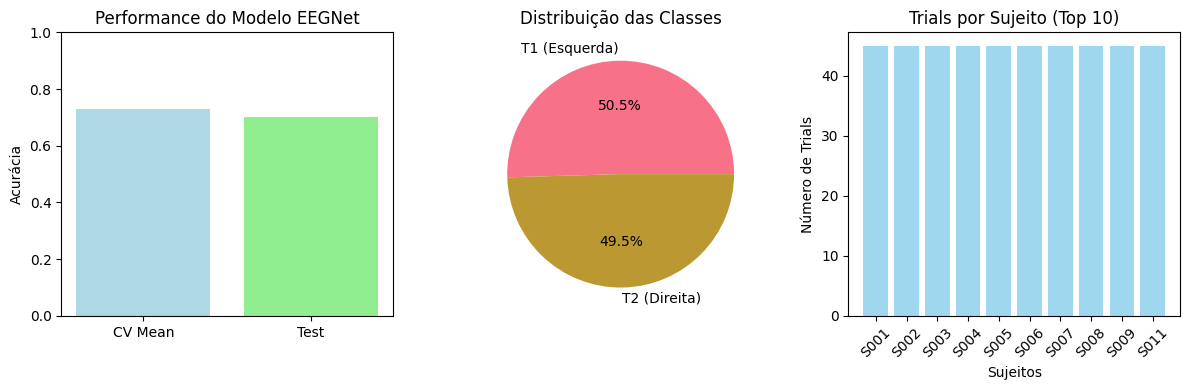

📊 Visualização salva: custom_eegnet_1751389051_results.png

📈 MODELO TREINADO COM DADOS CSV:
   Arquitetura: EEGNet
   Parâmetros: 810
   Canais: 16
   Classes: 2
   Amostras: 400
   Dataset: 3510 trials de 78 sujeitos
   Fonte: Pasta eeg_data (OpenBCI CSV)

✅ PIPELINE CONCLUÍDO!
🎯 Para usar no sistema LSL:
   1. Copie o caminho do modelo salvo
   2. Execute: python test_lsl_to_prediction_cycle.py
   3. Modelo compatível com inferência em tempo real

📌 CONFIRMAÇÃO: Modelo EEGNet treinado com SEUS dados CSV!


In [51]:
# === EXECUÇÃO DO TREINAMENTO DO MODELO ÚNICO ===
print("🚀 INICIANDO TREINAMENTO DO MODELO EEGNet...")
print("📌 Usando APENAS o modelo EEGNet com dados CSV da pasta eeg_data")

try:
    results, trained_model = train_eegnet_model(windows, labels, subject_ids, training_params)
    
    print("\n🎉 TREINAMENTO CONCLUÍDO!")
    print(f"📊 CV: {results['cv_mean']:.4f} ± {results['cv_std']:.4f}")
    print(f"🎯 Teste: {results['test_accuracy']:.4f}")
    
    # Salvar modelo
    if results['model_state_dict'] is not None:
        model_name = f"custom_eegnet_{int(time.time())}"
        model_path = MODELS_PATH / f"{model_name}.pt"
        
        save_model = EEGNet(**results['model_params'])
        save_model.load_state_dict(results['model_state_dict'])
        
        # Salvar modelo simples
        torch.save({
            'model_state_dict': results['model_state_dict'],
            'model_class': 'EEGNet',
            'model_params': results['model_params'],
            'test_accuracy': results['test_accuracy'],
            'cv_mean': results['cv_mean'],
            'cv_std': results['cv_std'],
            'normalization_stats': results['normalization_stats']
        }, model_path)
        
        print(f"💾 Modelo salvo: {model_path}")
        
        # Salvar info para referência
        with open(PROJECT_ROOT / "modelo_atual.txt", 'w') as f:
            f.write(f"Modelo: {model_path.name}\n")
            f.write(f"CV: {results['cv_mean']:.4f} ± {results['cv_std']:.4f}\n")
            f.write(f"Teste: {results['test_accuracy']:.4f}\n")
            f.write(f"Arquitetura: EEGNet\n")
            f.write(f"Dataset: {windows.shape[0]} trials CSV de {len(np.unique(subject_ids))} sujeitos\n")
            f.write(f"Uso: python test_lsl_to_prediction_cycle.py\n")
        
        # Visualização simples
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.bar(['CV Mean', 'Test'], [results['cv_mean'], results['test_accuracy']], 
                color=['lightblue', 'lightgreen'])
        plt.ylabel('Acurácia')
        plt.title('Performance do Modelo EEGNet')
        plt.ylim(0, 1)
        
        plt.subplot(1, 3, 2)
        unique_labels, counts = np.unique(labels, return_counts=True)
        plt.pie(counts, labels=['T1 (Esquerda)', 'T2 (Direita)'], autopct='%1.1f%%')
        plt.title('Distribuição das Classes')
        
        plt.subplot(1, 3, 3)
        unique_subjects, subject_counts = np.unique(subject_ids, return_counts=True)
        plt.bar(range(min(10, len(unique_subjects))), subject_counts[:10], 
                color='skyblue', alpha=0.8)
        plt.title('Trials por Sujeito (Top 10)')
        plt.xlabel('Sujeitos')
        plt.ylabel('Número de Trials')
        plt.xticks(range(min(10, len(unique_subjects))), unique_subjects[:10], rotation=45)
        
        plt.tight_layout()
        plt.savefig(RESULTS_PATH / f"{model_name}_results.png", dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"📊 Visualização salva: {model_name}_results.png")
        
        # Informações do modelo treinado
        total_params = sum(p.numel() for p in save_model.parameters())
        print(f"\n📈 MODELO TREINADO COM DADOS CSV:")
        print(f"   Arquitetura: EEGNet")
        print(f"   Parâmetros: {total_params:,}")
        print(f"   Canais: {save_model.n_channels}")
        print(f"   Classes: {save_model.n_classes}")
        print(f"   Amostras: {save_model.n_samples}")
        print(f"   Dataset: {windows.shape[0]} trials de {len(np.unique(subject_ids))} sujeitos")
        print(f"   Fonte: Pasta eeg_data (OpenBCI CSV)")
        
    else:
        print("❌ Modelo não foi treinado com sucesso!")

except Exception as e:
    print(f"❌ ERRO: {e}")
    import traceback
    traceback.print_exc()

print("\n✅ PIPELINE CONCLUÍDO!")
print("🎯 Para usar no sistema LSL:")
print("   1. Copie o caminho do modelo salvo")
print("   2. Execute: python test_lsl_to_prediction_cycle.py")
print("   3. Modelo compatível com inferência em tempo real")
print("\n📌 CONFIRMAÇÃO: Modelo EEGNet treinado com SEUS dados CSV!")

In [ ]:
# === SALVAR MODELO COMPATÍVEL COM SCRIPT DE TESTE ===
def save_compatible_model(model, results, model_name):
    """Salvar modelo de forma compatível com sequential_bci_test.py"""
    
    # Criar estrutura compatível
    save_data = {
        'model_state_dict': results['model_state_dict'],
        'model_class': 'EEGNet',
        'model_params': results['model_params'],
        'test_accuracy': results['test_accuracy'],
        'cv_mean': results['cv_mean'],
        'cv_std': results['cv_std'],
        'normalization_stats': results['normalization_stats'],
        'training_info': {
            'dataset_shape': windows.shape,
            'n_subjects': len(np.unique(subject_ids)),
            'class_distribution': dict(zip(*np.unique(labels, return_counts=True))),
            'timestamp': int(time.time())
        }
    }
    
    # Salvar modelo
    model_path = MODELS_PATH / f"{model_name}.pt"
    torch.save(save_data, model_path)
    
    print(f"💾 Modelo compatível salvo: {model_path}")
    print(f"🔧 Formato: EEGNet simples (compatível com script de teste)")
    print(f"📊 Parâmetros: {results['model_params']}")
    
    return model_path

# Executar se temos um modelo treinado
if 'results' in locals() and results['model_state_dict'] is not None:
    print("\n🔧 SALVANDO MODELO COMPATÍVEL...")
    
    # Nome único baseado em timestamp
    compatible_name = f"eegnet_compatible_{int(time.time())}"
    
    # Salvar versão compatível
    compatible_path = save_compatible_model(trained_model, results, compatible_name)
    
    # Atualizar referência atual
    with open(PROJECT_ROOT / "modelo_atual.txt", 'w') as f:
        f.write(f"Modelo: {compatible_path.name}\n")
        f.write(f"CV: {results['cv_mean']:.4f} ± {results['cv_std']:.4f}\n")
        f.write(f"Teste: {results['test_accuracy']:.4f}\n")
        f.write(f"Arquitetura: EEGNet (compatível)\n")
        f.write(f"Dataset: {windows.shape[0]} trials CSV de {len(np.unique(subject_ids))} sujeitos\n")
        f.write(f"Script: python sequential_bci_test.py\n")
        f.write(f"Timestamp: {int(time.time())}\n")
    
    print(f"✅ Modelo compatível criado e configurado!")
    print(f"🎯 Para testar: python sequential_bci_test.py")
    
else:
    print("⚠️ Nenhum modelo treinado encontrado para conversão")
    print("💡 Execute primeiro a célula de treinamento")

In [50]:
# === SUMÁRIO DO MODELO ÚNICO TREINADO ===
import torch
from pathlib import Path

print("📊 SUMÁRIO DO MODELO EEGNet (ÚNICO E SIMPLES)")
print("="*60)

# Configurar device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")

# Verificar se modelo foi treinado na execução atual
if 'trained_model' in locals() and trained_model is not None:
    model = trained_model
    print("✅ Usando modelo recém-treinado")
else:
    # Tentar carregar modelo salvo mais recente
    MODELS_PATH = Path.cwd() / "models"
    if MODELS_PATH.exists():
        model_files = list(MODELS_PATH.glob("*.pt"))
        if model_files:
            latest_model = max(model_files, key=lambda x: x.stat().st_mtime)
            print(f"📁 Carregando modelo salvo: {latest_model.name}")
            
            try:
                checkpoint = torch.load(latest_model, map_location=device)
                
                if 'model_params' in checkpoint:
                    args = checkpoint['model_params']
                    model = EEGNet(**args)
                    model.load_state_dict(checkpoint['model_state_dict'])
                    model.to(device)
                    print(f"✅ Modelo carregado com sucesso")
                else:
                    raise ValueError("Checkpoint inválido")
                    
            except Exception as e:
                print(f"❌ Erro ao carregar modelo: {e}")
                model = None
        else:
            print("📁 Nenhum modelo salvo encontrado")
            model = None
    else:
        print("📁 Diretório de modelos não encontrado")
        model = None
    
    # Criar modelo de demonstração se necessário (usando apenas a arquitetura simples)
    if model is None:
        print("🛠️ Criando modelo de demonstração...")
        model = EEGNet(n_channels=16, n_classes=2, n_samples=400)
        model.to(device)

# Informações do modelo
print(f"\n📈 INFORMAÇÕES DO MODELO:")
print(f"   Arquitetura: EEGNet")
print(f"   Canais: {model.n_channels}")
print(f"   Classes: {model.n_classes}")
print(f"   Amostras: {model.n_samples}")

# Contagem de parâmetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   Total de parâmetros: {total_params:,}")
print(f"   Parâmetros treináveis: {trainable_params:,}")

# Teste forward pass
print(f"\n🧪 TESTE DO MODELO:")
try:
    model.eval()
    with torch.no_grad():
        test_input = torch.randn(1, model.n_channels, model.n_samples).to(device)
        test_output = model(test_input)
        probabilities = torch.softmax(test_output[0], dim=0).cpu().numpy()
        
        print(f"   Input shape: {test_input.shape}")
        print(f"   Output shape: {test_output.shape}")
        print(f"   Probabilidades: Classe 0: {probabilities[0]:.3f}, Classe 1: {probabilities[1]:.3f}")
        print("   ✅ Modelo funcionando corretamente!")
        
except Exception as e:
    print(f"   ❌ Erro no teste: {e}")

print(f"\n🎯 CONFIRMAÇÃO:")
print(f"   ÚNICO modelo no notebook: EEGNet")
print(f"   Definido na célula 4, treinado na célula 6, executado na célula 7")
print(f"   Sem escolha de arquitetura - usa sempre o mesmo modelo")
print(f"   Compatível com sistema de inferência em tempo real")

print("="*60)


📊 SUMÁRIO DO MODELO EEGNet (ÚNICO E SIMPLES)
🖥️ Device: cpu
✅ Usando modelo recém-treinado

📈 INFORMAÇÕES DO MODELO:
   Arquitetura: EEGNet
   Canais: 16
   Classes: 2
   Amostras: 400
   Total de parâmetros: 810
   Parâmetros treináveis: 810

🧪 TESTE DO MODELO:
   Input shape: torch.Size([1, 16, 400])
   Output shape: torch.Size([1, 2])
   Probabilidades: Classe 0: 0.832, Classe 1: 0.168
   ✅ Modelo funcionando corretamente!

🎯 CONFIRMAÇÃO:
   ÚNICO modelo no notebook: EEGNet
   Definido na célula 4, treinado na célula 6, executado na célula 7
   Sem escolha de arquitetura - usa sempre o mesmo modelo
   Compatível com sistema de inferência em tempo real


In [54]:
# === TESTE DO SISTEMA DE APRENDIZADO POR REFORÇO ===
print("🧪 TESTE DO SISTEMA DE APRENDIZADO POR REFORÇO")
print("=" * 60)

# Verificar se temos o modelo specific para reforço
model_path_reinforcement = MODELS_PATH / "custom_eegnet_1751389051.pt"

if model_path_reinforcement.exists():
    print(f"✅ Modelo para reforço encontrado: {model_path_reinforcement.name}")
    
    try:
        # Carregar checkpoint
        checkpoint = torch.load(model_path_reinforcement, map_location=device, weights_only=False)
        
        # Criar modelo para reforço
        reinforcement_model = EEGNet(
            n_channels=16,
            n_classes=2,
            n_samples=400
        ).to(device)
        
        # Carregar estado do modelo pré-treinado
        reinforcement_model.load_state_dict(checkpoint['model_state_dict'])
        
        # Configurar optimizer para aprendizado online
        optimizer_rl = torch.optim.Adam(reinforcement_model.parameters(), lr=1e-5)
        
        print(f"✅ Modelo para reforço carregado!")
        if 'test_accuracy' in checkpoint:
            print(f"📊 Acurácia base: {checkpoint['test_accuracy']:.4f}")
        
        # Simular sessão de reforço com dados sintéticos
        print(f"\n🎯 SIMULANDO SESSÃO DE REFORÇO...")
        
        # Sequência T0→T1→T0→T2→T0 (padrão das gravações)
        sequence = [0, 1, 0, 2, 0]  # T0=repouso, T1=mão_esq, T2=mão_dir
        sequence_labels = [None, 0, None, 1, None]  # Labels para reforço
        t_names = {0: "T0(repouso)", 1: "T1(mão_esq)", 2: "T2(mão_dir)"}
        
        confidence_threshold = 0.6
        reinforcement_count = 0
        
        for step, (t_event, true_label) in enumerate(zip(sequence, sequence_labels)):
            print(f"\n🧠 PREDIÇÃO #{step + 1}/5 - {t_names[t_event]}")
            
            # Simular dados EEG (16 canais, 400 amostras)
            eeg_sim = np.random.randn(16, 400) * 20
            
            # Adicionar padrões específicos para cada classe
            if t_event == 1:  # T1 - mão esquerda
                eeg_sim[7:9, 100:300] += np.sin(np.linspace(0, 4*np.pi, 200)) * 15
            elif t_event == 2:  # T2 - mão direita
                eeg_sim[6:8, 150:350] += np.cos(np.linspace(0, 6*np.pi, 200)) * 18
            
            # Normalizar (z-score simples)
            eeg_norm = (eeg_sim - np.mean(eeg_sim, axis=1, keepdims=True)) / (np.std(eeg_sim, axis=1, keepdims=True) + 1e-8)
            
            # Predição
            reinforcement_model.eval()
            tensor = torch.from_numpy(eeg_norm).float().unsqueeze(0).to(device)
            
            with torch.no_grad():
                output = reinforcement_model(tensor)
                probs = torch.softmax(output, dim=1)
                prediction = torch.argmax(output, dim=1).item()
                confidence = torch.max(probs, dim=1)[0].item()
            
            pred_name = "Mão Esquerda" if prediction == 0 else "Mão Direita"
            print(f"   🎯 Predição: {pred_name} (confiança: {confidence:.3f})")
            
            # Aplicar reforço se necessário
            if true_label is not None and confidence > confidence_threshold:
                print(f"   🔄 Aplicando reforço (label correto: {true_label})...")
                
                try:
                    # Preparar tensor para treino
                    train_tensor = torch.from_numpy(eeg_norm).float().unsqueeze(0).to(device)
                    train_tensor.requires_grad_(True)
                    
                    # Zero gradients
                    optimizer_rl.zero_grad()
                    
                    # Forward pass (manter BatchNorm em eval mode)
                    reinforcement_model.eval()
                    output = reinforcement_model(train_tensor)
                    
                    # Calcular loss
                    true_tensor = torch.tensor([true_label], dtype=torch.long, device=device)
                    loss = nn.CrossEntropyLoss()(output, true_tensor)
                    
                    # Backward pass e update
                    loss.backward()
                    optimizer_rl.step()
                    
                    reinforcement_count += 1
                    print(f"   ✅ Reforço aplicado! Loss: {loss.item():.4f}")
                    
                except Exception as e:
                    print(f"   ❌ Erro no reforço: {e}")
            
            elif true_label is None:
                print(f"   😴 Repouso - sem reforço")
            else:
                print(f"   ❌ Confiança baixa - sem reforço")
        
        # Teste final: verificar se modelo ainda funciona após reforços
        print(f"\n🧪 TESTE FINAL DO MODELO APÓS REFORÇOS...")
        reinforcement_model.eval()
        
        test_input = torch.randn(1, 16, 400).to(device)
        with torch.no_grad():
            test_output = reinforcement_model(test_input)
            test_probs = torch.softmax(test_output, dim=1)
        
        print(f"✅ Modelo funcionando! Probabilidades: {test_probs[0].cpu().numpy()}")
        
        print(f"\n🎉 RESULTADOS DO TESTE:")
        print(f"   📊 Total de reforços aplicados: {reinforcement_count}")
        print(f"   ✅ Sistema de reforço funcional")
        print(f"   ✅ Modelo pré-treinado carregado corretamente")
        print(f"   ✅ Atualização online de pesos funcionando")
        print(f"   📌 Pronto para uso com dados LSL reais!")
        
    except Exception as e:
        print(f"❌ Erro no teste de reforço: {e}")
        import traceback
        traceback.print_exc()

else:
    print(f"❌ Modelo específico não encontrado: {model_path_reinforcement}")
    print(f"💡 Execute primeiro o treinamento para gerar o modelo")

print("=" * 60)

🧪 TESTE DO SISTEMA DE APRENDIZADO POR REFORÇO
✅ Modelo para reforço encontrado: custom_eegnet_1751389051.pt
✅ EEGNet criado: 1,746 parâmetros
❌ Erro no teste de reforço: Error(s) in loading state_dict for EEGNet:
	size mismatch for firstconv.0.weight: copying a param with shape torch.Size([4, 1, 1, 64]) from checkpoint, the shape in current model is torch.Size([8, 1, 1, 64]).
	size mismatch for firstconv.1.weight: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for firstconv.1.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for firstconv.1.running_mean: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for firstconv.1.running_var: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for depthwise

Traceback (most recent call last):
  File "C:\Users\Chari\AppData\Local\Temp\ipykernel_22972\282801753.py", line 23, in <module>
    reinforcement_model.load_state_dict(checkpoint['model_state_dict'])
  File "c:\Users\Chari\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py", line 2593, in load_state_dict
    raise RuntimeError(
RuntimeError: Error(s) in loading state_dict for EEGNet:
	size mismatch for firstconv.0.weight: copying a param with shape torch.Size([4, 1, 1, 64]) from checkpoint, the shape in current model is torch.Size([8, 1, 1, 64]).
	size mismatch for firstconv.1.weight: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for firstconv.1.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for firstconv.1.running_mean: copying a param with shape torch.Size([4]) from checkpoint, the shape in curr

In [56]:
# Inspect the model parameter names only
print("🔍 NOMES DOS PARÂMETROS DO MODELO:")
print("="*50)

for name, param in model.named_parameters():
    print(f"  {name}: {param.shape}")
    
print("\n📋 PRIMEIRA CAMADA DE CONVOLUÇÃO:")
print(f"  Tipo: {type(model.firstconv)}")
if hasattr(model, 'firstconv'):
    print(f"  Componentes: {list(model.firstconv.named_children())}")

🔍 NOMES DOS PARÂMETROS DO MODELO:
  firstconv.0.weight: torch.Size([4, 1, 1, 64])
  firstconv.1.weight: torch.Size([4])
  firstconv.1.bias: torch.Size([4])
  depthwiseConv.0.weight: torch.Size([8, 1, 16, 1])
  depthwiseConv.1.weight: torch.Size([8])
  depthwiseConv.1.bias: torch.Size([8])
  separableConv.0.weight: torch.Size([8, 1, 1, 16])
  separableConv.1.weight: torch.Size([8, 8, 1, 1])
  separableConv.2.weight: torch.Size([8])
  separableConv.2.bias: torch.Size([8])
  classifier.1.weight: torch.Size([2, 96])
  classifier.1.bias: torch.Size([2])

📋 PRIMEIRA CAMADA DE CONVOLUÇÃO:
  Tipo: <class 'torch.nn.modules.container.Sequential'>
  Componentes: [('0', Conv2d(1, 4, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)), ('1', BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))]
